In [3]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

In [2]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
 X = sparse.load_npz("../data/X_processed.npz")
X_test = sparse.load_npz("../data/X_test_processed.npz")
y = pd.read_csv("../data/y.csv")["SalePrice"].values


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_val.shape


((1168, 289), (292, 289))

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    "objective": "reg:squarederror",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse"
}

evals = [(dtrain, "train"), (dval, "val")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)


[0]	train-rmse:74085.86681	val-rmse:84276.33900
[50]	train-rmse:15435.81512	val-rmse:29098.92519
[100]	train-rmse:8672.43838	val-rmse:25421.37915
[150]	train-rmse:6800.47736	val-rmse:24789.92746
[200]	train-rmse:5410.33238	val-rmse:24591.42521
[250]	train-rmse:4262.01744	val-rmse:24446.59084
[300]	train-rmse:3359.32943	val-rmse:24395.03717
[350]	train-rmse:2722.99478	val-rmse:24362.32664
[400]	train-rmse:2195.03047	val-rmse:24368.68189
[410]	train-rmse:2092.76792	val-rmse:24364.36355


In [9]:
y_pred = xgb_model.predict(dval)


In [10]:
y_pred

array([142422.86 , 327910.06 , 111277.01 , 157203.62 , 313687.97 ,
        77700.59 , 225910.69 , 147413.73 ,  81519.555, 130804.67 ,
       152968.23 , 115856.84 , 107250.67 , 202478.84 , 171841.27 ,
       133325.4  , 195319.12 , 131329.33 , 119505.31 , 211840.47 ,
       152299.8  , 224890.95 , 171767.77 , 131121.84 , 201550.78 ,
       168345.98 , 198517.3  , 106734.56 , 174888.7  , 192627.14 ,
       127157.76 , 267359.88 , 178740.9  , 118388.516, 248438.6  ,
       147543.86 , 113348.59 , 207055.88 , 323134.62 , 106900.47 ,
       128107.12 , 233709.8  , 121087.8  , 378420.3  , 127181.74 ,
       139049.62 , 119216.23 , 127579.6  , 413494.12 , 137853.92 ,
       123826.72 , 196948.92 , 123516.53 , 324888.1  , 147737.72 ,
       256261.28 , 197377.02 , 151317.3  , 142507.66 , 106265.47 ,
        70728.375, 159392.52 , 315723.3  , 280795.03 , 275102.2  ,
       233797.6  , 108818.695, 318350.34 , 106938.055, 160885.11 ,
       123875.07 , 126302.414, 117350.2  ,  85618.984, 480796.

In [11]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mse  = mean_squared_error(y_val, y_pred)
mae  = mean_absolute_error(y_val, y_pred)
r2   = r2_score(y_val, y_pred)

print("Paper 1 XGBoost Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


Paper 1 XGBoost Performance:
RMSE: 24365.0840
MSE : 593657317.4781
MAE : 14926.6652
R²  : 0.9226


In [14]:
import pandas as pd
import numpy as np

# Load original train data
train_df = pd.read_csv("../data/train.csv")

# Identify numeric and categorical columns used in preprocessing
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove("SalePrice")  # remove target

categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

# Recreate the feature names after one-hot encoding
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe.fit(train_df[categorical_features])

feature_names_cat = ohe.get_feature_names_out(categorical_features)

# Combine numeric + categorical feature names
feature_names = np.concatenate([numeric_features, feature_names_cat])


/Users/shravanisajekar/miniconda3/envs/codehub/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


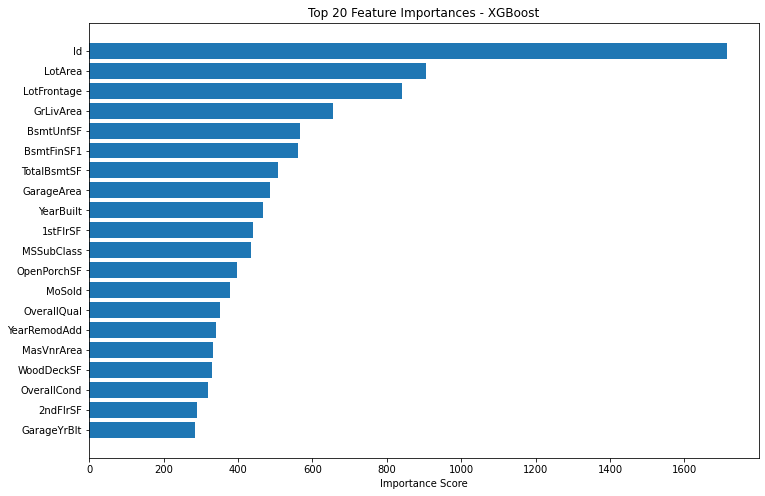

In [15]:
import matplotlib.pyplot as plt

# Get feature importance from XGBoost model
importances = xgb_model.get_score(importance_type='weight')
importance_dict = {feature_names[int(k[1:])]: v for k, v in importances.items()}

# Top 20 features
sorted_feat = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]
labels = [k for k, v in sorted_feat]
scores = [v for k, v in sorted_feat]

plt.figure(figsize=(12,8))
plt.barh(labels[::-1], scores[::-1])  # largest on top
plt.xlabel("Importance Score")
plt.title("Top 20 Feature Importances - XGBoost")
plt.show()


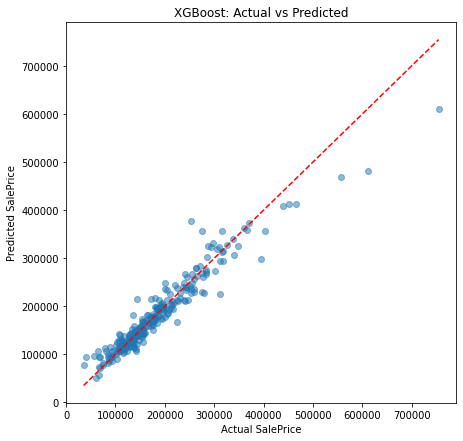

In [16]:
import matplotlib.pyplot as plt

y_pred = xgb_model.predict(xgb.DMatrix(X_val))

plt.figure(figsize=(7,7))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("XGBoost: Actual vs Predicted")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.show()


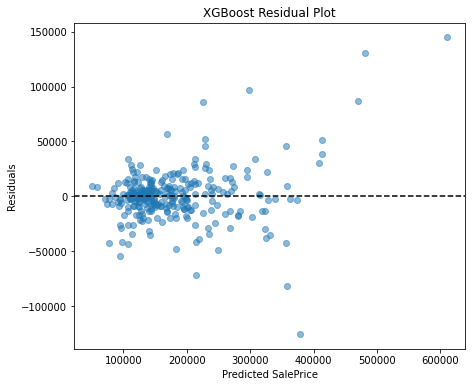

In [17]:
residuals = y_val - y_pred

plt.figure(figsize=(7,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("XGBoost Residual Plot")
plt.show()


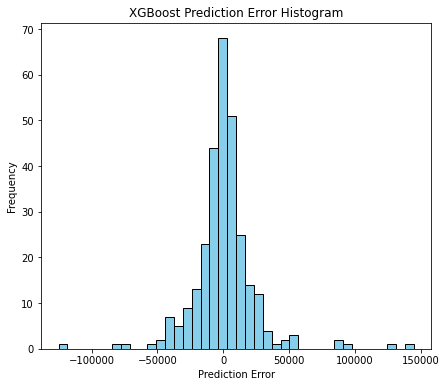

In [18]:
plt.figure(figsize=(7,6))
plt.hist(residuals, bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("XGBoost Prediction Error Histogram")
plt.show()


In [37]:
import numpy as np

# Save validation predictions
np.save("../data/paper1_xgb_val_predictions.npy", y_pred)

# Optional: Save test set predictions
y_test_pred = xgb_model.predict(xgb.DMatrix(X_test))
np.save("../data/paper1_xgb_test_predictions.npy", y_test_pred)


In [38]:
metrics = {
    "RMSE": rmse,
    "MSE": mse,
    "MAE": mae,
    "R2": r2
}
import json
with open("../data/paper1_xgb_metrics.json", "w") as f:
    json.dump(metrics, f)
